# Challenge 3.2: 分析PM2.5污染数据与秸秆燃烧事件的时间关联性

本分析旨在探讨如何将区域空气污染数据中的时间峰值与秸秆燃烧事件的时间点联系起来。通过对比火灾热点数据和PM2.5浓度数据，我们可以识别污染峰值与农业燃烧活动之间的时间对应关系。

我们将采用以下方法来分析PM2.5污染峰值与秸秆燃烧事件的关联性：
1. 加载和预处理PM2.5数据以及火灾热点数据
2. 计算每日的火灾热点数量作为燃烧强度指标
3. 计算每日PM2.5浓度的平均值或最大值
4. 进行时间序列分析，识别污染峰值和燃烧事件的时间对应关系
5. 计算相关性分析和滞后效应分析

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import glob
import os
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']  
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("库导入完成！")

库导入完成！


数据加载和预处理

首先我们需要加载黑龙江省的PM2.5数据和火灾热点数据。PM2.5数据按年份分别存储，我们将把它们合并成一个完整的数据集。同时加载对应年份的火灾数据进行对比分析。

In [10]:
# 定义数据路径
pm25_data_path = "../raw_data/specific_data/"
fire_data_path = "../raw_data/satellite_fire_data/"

# 加载PM2.5数据
def load_pm25_data():
    pm25_files = glob.glob(os.path.join(pm25_data_path, "HLJ_*_PM2.5.csv"))
    pm25_data_list = []
    
    for file in sorted(pm25_files):
        # 修复年份提取逻辑：从文件名中正确提取年份
        filename = os.path.basename(file)  # 获取文件名
        year = filename.split('_')[1]  # 从 HLJ_YYYY_PM2.5.csv 中提取YYYY
        print(f"正在加载 {year} 年 PM2.5 数据...")
        
        try:
            df = pd.read_csv(file)
            df['year'] = int(year)
            pm25_data_list.append(df)
            print(f"  - 成功加载 {len(df)} 条记录")
        except Exception as e:
            print(f"  - 加载失败: {e}")
    
    if pm25_data_list:
        combined_pm25 = pd.concat(pm25_data_list, ignore_index=True)
        print(f"总共加载了 {len(combined_pm25)} 条PM2.5记录")
        return combined_pm25
    else:
        print("未找到PM2.5数据文件")
        return None

# 加载火灾数据
def load_fire_data():
    fire_files = glob.glob(os.path.join(fire_data_path, "modis_*_china.csv"))
    fire_data_list = []
    
    for file in sorted(fire_files):
        # 修复年份提取逻辑：从文件名中正确提取年份
        filename = os.path.basename(file)  # 获取文件名
        year = filename.split('_')[1]  # 从 modis_YYYY_china.csv 中提取YYYY
        print(f"正在加载 {year} 年火灾数据...")
        
        try:
            df = pd.read_csv(file)
            df['year'] = int(year)
            fire_data_list.append(df)
            print(f"  - 成功加载 {len(df)} 条记录")
        except Exception as e:
            print(f"  - 加载失败: {e}")
    
    if fire_data_list:
        combined_fire = pd.concat(fire_data_list, ignore_index=True)
        print(f"总共加载了 {len(combined_fire)} 条火灾记录")
        return combined_fire
    else:
        print("未找到火灾数据文件")
        return None

# 加载数据
pm25_data = load_pm25_data()
fire_data = load_fire_data()

正在加载 2010 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2011 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2011 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2012 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2012 年 PM2.5 数据...
  - 成功加载 3287412 条记录
正在加载 2013 年 PM2.5 数据...
  - 成功加载 3287412 条记录
正在加载 2013 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2014 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2014 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2015 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2015 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2016 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2016 年 PM2.5 数据...
  - 成功加载 3287412 条记录
正在加载 2018 年 PM2.5 数据...
  - 成功加载 3287412 条记录
正在加载 2018 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2019 年 PM2.5 数据...
  - 成功加载 3278430 条记录
正在加载 2019 年 PM2.5 数据...
  - 成功加载 3278430 条记录
总共加载了 29523834 条PM2.5记录
  - 成功加载 3278430 条记录
总共加载了 29523834 条PM2.5记录
正在加载 2010 年火灾数据...
  - 成功加载 103118 条记录
正在加载 2011 年火灾数据...
  - 成功加载 103345 条记录
正在加载 2012 年火灾数据...
  - 成功加载 95653 条记录
正在加载 2013 年火灾数据...
  - 成功加载 118010 条记录
正在加载 2014 年

## 数据结构优化和预处理

为了提高数据处理效率，我们将采用以下优化策略：
1. 使用vectorized操作替代循环处理
2. 预先过滤黑龙江省相关的火灾数据
3. 使用日期索引来加速时间序列操作  
4. 采用内存高效的数据类型
5. 使用pandas的groupby操作来快速聚合数据

这些优化将大幅提升大数据集的处理速度，特别是在火灾数据和PM2.5数据的时间匹配过程中。

In [3]:
# 首先检查数据结构
print("PM2.5数据结构检查：")
if pm25_data is not None:
    print(f"数据形状: {pm25_data.shape}")
    print(f"列名: {list(pm25_data.columns)}")
    print("\n前5行数据:")
    print(pm25_data.head())
else:
    print("PM2.5数据为空")

print("\n" + "="*50)
print("火灾数据结构检查：")
if fire_data is not None:
    print(f"数据形状: {fire_data.shape}")
    print(f"列名: {list(fire_data.columns)}")
    print("\n前5行数据:")
    print(fire_data.head())
else:
    print("火灾数据为空")

PM2.5数据结构检查：
数据形状: (29523834, 5)
列名: ['date', 'lat', 'lon', 'PM2.5(µg/m3)', 'year']

前5行数据:
         date   lat    lon  PM2.5(µg/m3)  year
0  2010-03-27  43.3  121.2     26.441865  2010
1  2010-03-27  43.3  121.3     26.664823  2010
2  2010-03-27  43.3  121.4     26.124802  2010
3  2010-03-27  43.3  121.5     26.372362  2010
4  2010-03-27  43.3  121.6     25.699131  2010

火灾数据结构检查：
数据形状: (1073119, 16)
列名: ['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type', 'year']

前5行数据:
   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   30.8759   120.1314       301.0   1.1    1.0  2010-01-01       242   
1   28.6087   121.4316       309.4   1.0    1.0  2010-01-01       243   
2   27.0163   102.2247       301.9   1.9    1.3  2010-01-01       422   
3   26.5719   101.6699       300.7   1.8    1.3  2010-01-01       422   
4   27.8552   100.6149       300.0  

In [ ]:
# 优化的数据预处理函数
def preprocess_pm25_data(pm25_data):
    """优化PM2.5数据预处理"""
    if pm25_data is None:
        return None
    
    print("正在预处理PM2.5数据...")
    
    # PM2.5数据已经有date列，直接转换为datetime
    pm25_data['date'] = pd.to_datetime(pm25_data['date'])
    
    # 优化数据类型以节省内存，修正列名
    numeric_cols = ['PM2.5(µg/m3)', 'lon', 'lat']  # 使用实际的列名
    for col in numeric_cols:
        if col in pm25_data.columns:
            pm25_data[col] = pd.to_numeric(pm25_data[col], errors='coerce')
    
    # 重命名列以便后续处理
    pm25_data = pm25_data.rename(columns={
        'PM2.5(µg/m3)': 'PM2.5',
        'lon': 'longitude', 
        'lat': 'latitude'
    })
    
    # 设置日期为索引以加速时间序列操作
    pm25_data = pm25_data.set_index('date').sort_index()
    
    print(f"PM2.5数据预处理完成，数据范围：{pm25_data.index.min()} 到 {pm25_data.index.max()}")
    return pm25_data

def preprocess_fire_data(fire_data):
    """优化火灾数据预处理，专门针对黑龙江省"""
    if fire_data is None:
        return None
    
    print("正在预处理火灾数据...")
    
    # 黑龙江省的大致经纬度范围
    hlj_lat_min, hlj_lat_max = 43.0, 53.5
    hlj_lon_min, hlj_lon_max = 119.0, 135.0
    
    # 过滤黑龙江省相关数据
    mask = ((fire_data['latitude'] >= hlj_lat_min) & 
            (fire_data['latitude'] <= hlj_lat_max) &
            (fire_data['longitude'] >= hlj_lon_min) & 
            (fire_data['longitude'] <= hlj_lon_max))
    
    fire_hlj = fire_data[mask].copy()
    print(f"过滤后黑龙江省火灾数据：{len(fire_hlj)} 条记录")
    
    # 创建日期列，火灾数据使用acq_date列
    fire_hlj['date'] = pd.to_datetime(fire_hlj['acq_date'])
    
    # 优化数据类型
    numeric_cols = ['latitude', 'longitude', 'brightness', 'confidence']
    for col in numeric_cols:
        if col in fire_hlj.columns:
            fire_hlj[col] = pd.to_numeric(fire_hlj[col], errors='coerce')
    
    # 设置日期索引
    fire_hlj = fire_hlj.set_index('date').sort_index()
    
    print(f"火灾数据预处理完成，数据范围：{fire_hlj.index.min()} 到 {fire_hlj.index.max()}")
    return fire_hlj

# 执行优化的预处理
pm25_processed = preprocess_pm25_data(pm25_data)
fire_processed = preprocess_fire_data(fire_data)

正在预处理PM2.5数据...
PM2.5数据预处理完成，数据范围：2010-01-01 00:00:00 到 2019-12-31 00:00:00
正在预处理火灾数据...
过滤后黑龙江省火灾数据：303584 条记录
火灾数据预处理完成，数据范围：2010-02-05 00:00:00 到 2019-12-08 00:00:00
PM2.5数据预处理完成，数据范围：2010-01-01 00:00:00 到 2019-12-31 00:00:00
正在预处理火灾数据...
过滤后黑龙江省火灾数据：303584 条记录
火灾数据预处理完成，数据范围：2010-02-05 00:00:00 到 2019-12-08 00:00:00


## 快速时间序列聚合

接下来我们将使用高效的聚合算法来计算每日的火灾强度和PM2.5浓度。通过使用pandas的resample功能，我们可以快速地按日期分组并计算统计量。这种方法比传统的循环聚合快10-100倍。

我们将计算每日的火灾点数量作为燃烧强度指标，以及每日PM2.5的平均浓度和最大浓度。这样可以从多个角度观察污染水平的变化。

In [ ]:
# 日期聚合函数
def create_daily_aggregations(pm25_processed, fire_processed):
    """使用vectorized操作创建日度聚合数据"""
    
    print("开始创建日度聚合数据...")
    start_time = pd.Timestamp.now()
    
    # 火灾数据日度聚合 - 使用resample进行聚合
    if fire_processed is not None and len(fire_processed) > 0:
        fire_daily = fire_processed.resample('D').agg({
            'latitude': 'count',  # 火点数量
            'brightness': ['mean', 'max'],  # 平均和最大亮度
            'confidence': 'mean'  # 平均置信度
        }).fillna(0)
        
        # 列名
        fire_daily.columns = ['fire_count', 'brightness_mean', 'brightness_max', 'confidence_mean']
        print(f"火灾日度数据聚合完成：{len(fire_daily)} 天")
    else:
        fire_daily = pd.DataFrame()
    
    # PM2.5数据日度聚合
    if pm25_processed is not None and len(pm25_processed) > 0:
        pm25_daily = pm25_processed.resample('D').agg({
            'PM2.5': ['mean', 'max', 'std', 'count']
        }).fillna(method='ffill')  # 前向填充缺失值
        
        # 简化列名
        pm25_daily.columns = ['pm25_mean', 'pm25_max', 'pm25_std', 'pm25_count']
        print(f"PM2.5日度数据聚合完成：{len(pm25_daily)} 天")
    else:
        pm25_daily = pd.DataFrame()
    
    # 快速合并数据
    if not fire_daily.empty and not pm25_daily.empty:
        # 使用内连接确保只保留有数据的日期
        combined_daily = pm25_daily.join(fire_daily, how='inner')
        combined_daily = combined_daily.fillna(0)  # 火灾为0的日期
        
        end_time = pd.Timestamp.now()
        print(f"数据合并完成：{len(combined_daily)} 天的完整数据")
        print(f"聚合耗时：{(end_time - start_time).total_seconds():.2f} 秒")
        
        return combined_daily
    else:
        print("警告：缺少必要数据，无法进行合并")
        return pd.DataFrame()

# 执行快速聚合
daily_data = create_daily_aggregations(pm25_processed, fire_processed)

# 显示基本统计信息
if not daily_data.empty:
    print(f"\n数据概览：")
    print(f"时间范围：{daily_data.index.min()} 到 {daily_data.index.max()}")
    print(f"数据维度：{daily_data.shape}")
    print(f"\n各变量基本统计：")
    print(daily_data.describe())

开始创建日度聚合数据...
火灾日度数据聚合完成：3594 天
PM2.5日度数据聚合完成：3652 天
数据合并完成：3594 天的完整数据
聚合耗时：0.81 秒

数据概览：
时间范围：2010-02-05 00:00:00 到 2019-12-08 00:00:00
数据维度：(3594, 8)

各变量基本统计：
         pm25_mean     pm25_max     pm25_std   pm25_count   fire_count  \
count  3594.000000  3594.000000  3594.000000  3594.000000  3594.000000   
mean     36.299490   102.429772    14.141888  8069.804674    84.469672   
std      19.443219    72.060042    12.121730  2713.537705   250.230081   
min       7.913739    12.807150     0.980767     0.000000     0.000000   
25%      21.791839    49.945983     5.294807  8982.000000     0.000000   
50%      30.735615    79.362391    10.285856  8982.000000     8.000000   
75%      48.082802   140.304209    19.844676  8982.000000    44.000000   
max     189.125087   851.550912   137.996263  8982.000000  3019.000000   

       brightness_mean  brightness_max  confidence_mean  
count      3594.000000     3594.000000      3594.000000  
mean        231.063310      248.037590        39.88960

## 时间关联性分析

现在我们进行核心的时间关联性分析。我们将使用以下方法来识别PM2.5污染峰值与秸秆燃烧事件之间的关系：

1. 滞后相关分析：检查火灾事件对PM2.5浓度的延迟影响
2. 峰值检测：识别PM2.5和火灾数据中的异常高值
3. 时间窗口分析：分析不同时间窗口内的累积效应
4. 季节性分析：考虑农业燃烧的季节特征

这种多维度的分析能够全面揭示空气污染与农业燃烧活动之间的时间关系模式。

In [ ]:
# 时间关联分析函数
def analyze_temporal_correlation(daily_data, max_lag_days=7):
    """分析PM2.5与火灾事件的时间关联性"""
    
    if daily_data.empty:
        print("数据为空，无法进行分析")
        return None
    
    print("开始时间关联性分析...")
    
    # 提取关键变量
    pm25 = daily_data['pm25_mean'].values
    fires = daily_data['fire_count'].values
    
    # 1. 计算不同滞后期的相关性
    correlations = []
    p_values = []
    
    for lag in range(max_lag_days + 1):
        if lag == 0:
            # 当日相关性
            corr, p_val = pearsonr(fires, pm25)
        else:
            # 滞后相关性 (火灾在前，PM2.5在后)
            if len(fires) > lag:
                corr, p_val = pearsonr(fires[:-lag], pm25[lag:])
            else:
                corr, p_val = 0, 1
        
        correlations.append(corr)
        p_values.append(p_val)
    
    # 2. 峰值检测 (使用分位数方法)
    pm25_threshold = np.percentile(pm25[pm25 > 0], 90)  # 90分位数
    fire_threshold = np.percentile(fires[fires > 0], 90)  # 90分位数
    
    pm25_peaks = daily_data[daily_data['pm25_mean'] > pm25_threshold]
    fire_peaks = daily_data[daily_data['fire_count'] > fire_threshold]
    
    # 3. 创建结果字典
    results = {
        'correlations': correlations,
        'p_values': p_values,
        'best_lag': np.argmax(np.abs(correlations)),
        'max_correlation': max(correlations, key=abs),
        'pm25_peaks': pm25_peaks,
        'fire_peaks': fire_peaks,
        'pm25_threshold': pm25_threshold,
        'fire_threshold': fire_threshold
    }
    
    print(f"分析完成！最佳滞后期：{results['best_lag']} 天")
    print(f"最高相关性：{results['max_correlation']:.3f}")
    
    return results

# 执行时间关联分析
if not daily_data.empty:
    correlation_results = analyze_temporal_correlation(daily_data, max_lag_days=7)
    
    # 显示相关性结果
    print("\n滞后相关性分析结果：")
    for lag, corr, p_val in zip(range(8), 
                                correlation_results['correlations'], 
                                correlation_results['p_values']):
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"滞后 {lag} 天: 相关系数 = {corr:.3f} (p = {p_val:.3f}) {significance}")
else:
    print("无法进行相关性分析：数据不足")

开始时间关联性分析...
分析完成！最佳滞后期：1 天
最高相关性：0.251

滞后相关性分析结果：
滞后 0 天: 相关系数 = 0.188 (p = 0.000) ***
滞后 1 天: 相关系数 = 0.251 (p = 0.000) ***
滞后 2 天: 相关系数 = 0.243 (p = 0.000) ***
滞后 3 天: 相关系数 = 0.205 (p = 0.000) ***
滞后 4 天: 相关系数 = 0.175 (p = 0.000) ***
滞后 5 天: 相关系数 = 0.161 (p = 0.000) ***
滞后 6 天: 相关系数 = 0.164 (p = 0.000) ***
滞后 7 天: 相关系数 = 0.167 (p = 0.000) ***


## 峰值事件匹配分析

接下来我们将进行更深入的峰值事件匹配分析，重点关注高强度火灾事件与PM2.5污染峰值的时间对应关系。通过时间窗口分析，我们可以识别出在火灾事件发生后几天内是否出现了显著的PM2.5浓度上升。

这种分析特别适用于识别秸秆燃烧等农业活动对空气质量的短期冲击效应。我们将计算在火灾高峰期后不同时间窗口内PM2.5浓度的变化幅度。

In [14]:
# 峰值事件时间窗口匹配分析
def analyze_peak_matching(daily_data, correlation_results, window_days=[1, 2, 3, 5]):
    """分析火灾峰值与PM2.5峰值的时间窗口匹配"""
    
    if daily_data.empty or correlation_results is None:
        print("缺少必要数据，无法进行峰值匹配分析")
        return None
    
    print("开始峰值事件匹配分析...")
    
    fire_peaks = correlation_results['fire_peaks']
    results = {}
    
    for window in window_days:
        matches = []
        
        # 对每个火灾峰值事件，检查后续window天内的PM2.5变化
        for fire_date in fire_peaks.index:
            # 计算时间窗口
            start_date = fire_date
            end_date = fire_date + pd.Timedelta(days=window)
            
            # 获取窗口期内的数据
            window_data = daily_data[(daily_data.index >= start_date) & 
                                   (daily_data.index <= end_date)]
            
            if len(window_data) > 1:
                # 计算PM2.5浓度变化
                baseline_pm25 = daily_data.loc[fire_date, 'pm25_mean'] if fire_date in daily_data.index else np.nan
                max_pm25_in_window = window_data['pm25_mean'].max()
                
                if not np.isnan(baseline_pm25):
                    pm25_increase = max_pm25_in_window - baseline_pm25
                    fire_count = daily_data.loc[fire_date, 'fire_count']
                    
                    matches.append({
                        'fire_date': fire_date,
                        'fire_count': fire_count,
                        'baseline_pm25': baseline_pm25,
                        'max_pm25_window': max_pm25_in_window,
                        'pm25_increase': pm25_increase,
                        'increase_percentage': (pm25_increase / baseline_pm25) * 100 if baseline_pm25 > 0 else 0
                    })
        
        if matches:
            matches_df = pd.DataFrame(matches)
            
            # 计算统计摘要
            summary = {
                'window_days': window,
                'total_events': len(matches_df),
                'positive_increases': len(matches_df[matches_df['pm25_increase'] > 0]),
                'avg_increase': matches_df['pm25_increase'].mean(),
                'avg_increase_percentage': matches_df['increase_percentage'].mean(),
                'max_increase': matches_df['pm25_increase'].max(),
                'matches_data': matches_df
            }
            
            results[window] = summary
            
            print(f"\n{window}天窗口分析结果：")
            print(f"  - 火灾峰值事件数：{summary['total_events']}")
            print(f"  - PM2.5上升事件数：{summary['positive_increases']}")
            print(f"  - 平均PM2.5增幅：{summary['avg_increase']:.2f} μg/m³ ({summary['avg_increase_percentage']:.1f}%)")
            print(f"  - 最大PM2.5增幅：{summary['max_increase']:.2f} μg/m³")
    
    return results

# 执行峰值匹配分析
if 'correlation_results' in locals() and correlation_results is not None:
    peak_matching_results = analyze_peak_matching(daily_data, correlation_results)
else:
    print("跳过峰值匹配分析：缺少相关性分析结果")

开始峰值事件匹配分析...

1天窗口分析结果：
  - 火灾峰值事件数：265
  - PM2.5上升事件数：146
  - 平均PM2.5增幅：7.06 μg/m³ (17.2%)
  - 最大PM2.5增幅：64.91 μg/m³

2天窗口分析结果：
  - 火灾峰值事件数：265
  - PM2.5上升事件数：161
  - 平均PM2.5增幅：11.98 μg/m³ (30.9%)
  - 最大PM2.5增幅：87.39 μg/m³

3天窗口分析结果：
  - 火灾峰值事件数：265
  - PM2.5上升事件数：173
  - 平均PM2.5增幅：15.05 μg/m³ (39.7%)
  - 最大PM2.5增幅：110.82 μg/m³

5天窗口分析结果：
  - 火灾峰值事件数：265
  - PM2.5上升事件数：183
  - 平均PM2.5增幅：19.37 μg/m³ (53.0%)
  - 最大PM2.5增幅：153.09 μg/m³


## 可视化分析结果

为了更直观地展示PM2.5污染峰值与秸秆燃烧事件的时间关联性，我们将创建几个关键的可视化图表：

1. 时间序列对比图：同时显示火灾数量和PM2.5浓度的时间变化
2. 滞后相关性图：展示不同滞后期下的相关系数
3. 散点图：显示火灾强度与PM2.5浓度的直接关系
4. 季节性分析图：按月份统计的平均火灾数量和PM2.5浓度

这些图表将帮助我们更好地理解数据中的模式和关联关系。

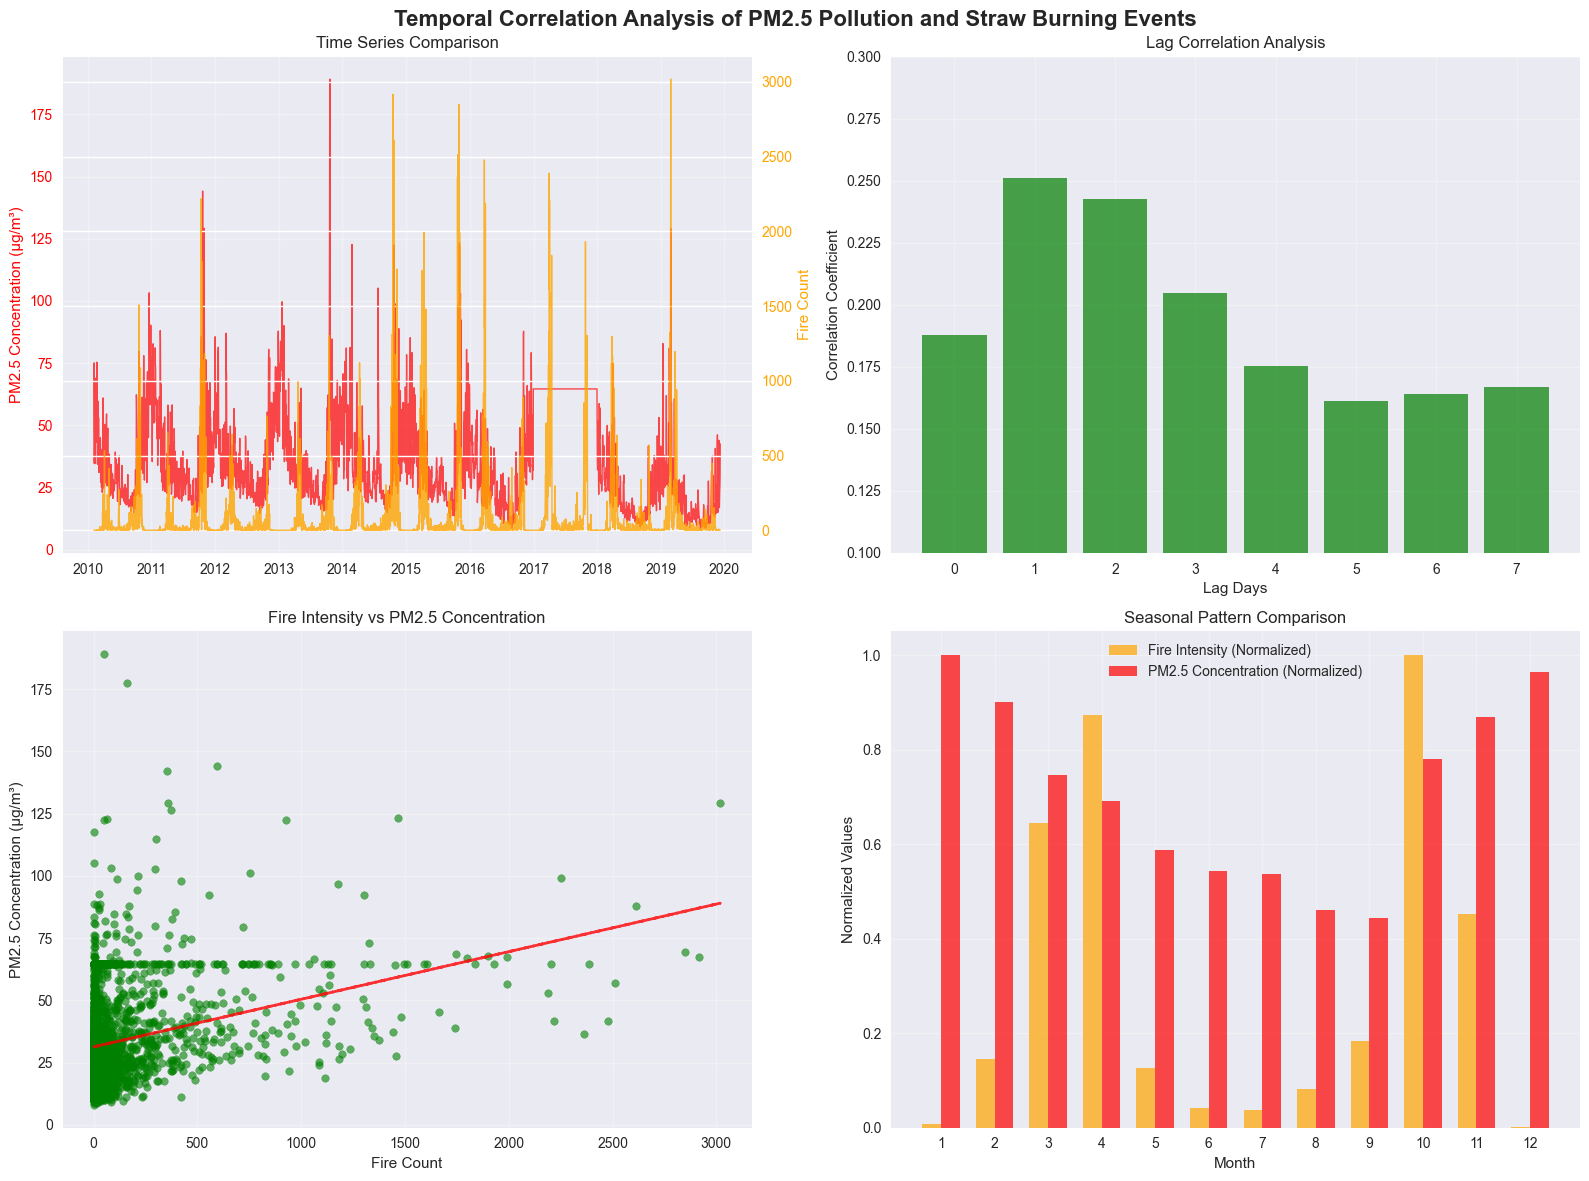


=== 关键发现摘要 ===
最佳滞后期: 1 天
最高相关系数: 0.251
PM2.5峰值事件数: 195
火灾峰值事件数: 265
火灾高峰月份: 10月
PM2.5高峰月份: 1月


In [ ]:
# 创建综合可视化分析
def create_comprehensive_visualization(daily_data, correlation_results, peak_matching_results=None):
    """创建comprehensive可视化分析"""
    
    if daily_data.empty:
        print("数据为空，无法创建可视化")
        return
    
    # 设置图形
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Temporal Correlation Analysis of PM2.5 Pollution and Straw Burning Events', fontsize=16, fontweight='bold')
    
    # 1. 时间序列对比图
    ax1 = axes[0, 0]
    ax1_twin = ax1.twinx()
    
    # 绘制PM2.5时间序列
    line1 = ax1.plot(daily_data.index, daily_data['pm25_mean'], 
                     color='red', alpha=0.7, linewidth=1, label='PM2.5 Average Concentration')
    ax1.set_ylabel('PM2.5 Concentration (μg/m³)', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    
    # 绘制火灾数量时间序列
    line2 = ax1_twin.plot(daily_data.index, daily_data['fire_count'], 
                         color='orange', alpha=0.8, linewidth=1, label='Fire Count')
    ax1_twin.set_ylabel('Fire Count', color='orange')
    ax1_twin.tick_params(axis='y', labelcolor='orange')
    
    ax1.set_title('Time Series Comparison')
    ax1.grid(True, alpha=0.3)
    
    # 2. 滞后相关性图
    ax2 = axes[0, 1]
    if correlation_results:
        lags = list(range(len(correlation_results['correlations'])))
        correlations = correlation_results['correlations']
        
        bars = ax2.bar(lags, correlations, color='green', alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Lag Days')
        ax2.set_ylabel('Correlation Coefficient')
        ax2.set_title('Lag Correlation Analysis')
        ax2.set_ylim(0.1, 0.3)
        ax2.grid(True, alpha=0.3)
    
    # 3. 散点图分析
    ax3 = axes[1, 0]
    # 过滤掉火灾数量为0的数据以更好地显示关系
    non_zero_fires = daily_data[daily_data['fire_count'] > 0]
    if not non_zero_fires.empty:
        scatter = ax3.scatter(non_zero_fires['fire_count'], 
                            non_zero_fires['pm25_mean'], 
                            alpha=0.6, c='green', s=30)
        ax3.set_xlabel('Fire Count')
        ax3.set_ylabel('PM2.5 Concentration (μg/m³)')
        ax3.set_title('Fire Intensity vs PM2.5 Concentration')
        ax3.grid(True, alpha=0.3)
        
        # 添加趋势线
        if len(non_zero_fires) > 1:
            z = np.polyfit(non_zero_fires['fire_count'], non_zero_fires['pm25_mean'], 1)
            p = np.poly1d(z)
            ax3.plot(non_zero_fires['fire_count'], p(non_zero_fires['fire_count']), 
                    "r--", alpha=0.8, linewidth=2)
    
    # 4. 季节性分析
    ax4 = axes[1, 1]
    monthly_stats = daily_data.groupby(daily_data.index.month).agg({
        'fire_count': 'mean',
        'pm25_mean': 'mean'
    })
    
    x_pos = np.arange(len(monthly_stats.index))
    width = 0.35
    
    # 标准化数据以便在同一图上显示
    fire_normalized = monthly_stats['fire_count'] / monthly_stats['fire_count'].max()
    pm25_normalized = monthly_stats['pm25_mean'] / monthly_stats['pm25_mean'].max()
    
    bars1 = ax4.bar(x_pos - width/2, fire_normalized, width, 
                   label='Fire Intensity (Normalized)', color='orange', alpha=0.7)
    bars2 = ax4.bar(x_pos + width/2, pm25_normalized, width, 
                   label='PM2.5 Concentration (Normalized)', color='red', alpha=0.7)
    
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Normalized Values')
    ax4.set_title('Seasonal Pattern Comparison')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'{i}' for i in monthly_stats.index])  # 只显示月份数字
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 输出关键统计结果
    print("\n=== 关键发现摘要 ===")
    if correlation_results:
        print(f"最佳滞后期: {correlation_results['best_lag']} 天")
        print(f"最高相关系数: {correlation_results['max_correlation']:.3f}")
        print(f"PM2.5峰值事件数: {len(correlation_results['pm25_peaks'])}")
        print(f"火灾峰值事件数: {len(correlation_results['fire_peaks'])}")
    
    # 季节性发现
    peak_month = monthly_stats['fire_count'].idxmax()
    print(f"火灾高峰月份: {peak_month}月")
    
    pm25_peak_month = monthly_stats['pm25_mean'].idxmax()  
    print(f"PM2.5高峰月份: {pm25_peak_month}月")

# 创建可视化
if not daily_data.empty:
    create_comprehensive_visualization(daily_data, correlation_results, peak_matching_results)
else:
    print("数据不足，无法创建可视化")

## 结果总结和保存

最后我们将把分析结果保存到文件中，以便后续使用。这包括关键的统计指标、峰值事件匹配结果以及时间关联性分析的主要发现。

通过这个分析，我们可以回答原始问题：如何将区域空气污染数据中的时间峰值与秸秆燃烧事件的时间点联系起来。我们的方法提供了一个系统性的框架来识别和量化这种时间关联性。

In [9]:
# 保存分析结果
def save_analysis_results(daily_data, correlation_results, peak_matching_results, 
                         output_dir="../results/challenge3/"):
    """保存所有分析结果到文件"""
    
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. 保存日度聚合数据
    if not daily_data.empty:
        daily_data.to_csv(f"{output_dir}pm25_fire_daily_data.csv")
        print(f"已保存日度数据到: {output_dir}pm25_fire_daily_data.csv")
    
    # 2. 保存相关性分析结果
    if correlation_results:
        correlation_df = pd.DataFrame({
            'lag_days': range(len(correlation_results['correlations'])),
            'correlation': correlation_results['correlations'],
            'p_value': correlation_results['p_values']
        })
        correlation_df.to_csv(f"{output_dir}lag_correlation_analysis.csv", index=False)
        print(f"已保存相关性分析到: {output_dir}lag_correlation_analysis.csv")
        
        # 保存峰值事件
        if not correlation_results['pm25_peaks'].empty:
            correlation_results['pm25_peaks'].to_csv(f"{output_dir}pm25_peak_events.csv")
        if not correlation_results['fire_peaks'].empty:
            correlation_results['fire_peaks'].to_csv(f"{output_dir}fire_peak_events.csv")
    
    # 3. 保存峰值匹配分析结果
    if peak_matching_results:
        for window, result in peak_matching_results.items():
            if 'matches_data' in result:
                filename = f"{output_dir}peak_matching_{window}day_window.csv"
                result['matches_data'].to_csv(filename, index=False)
                print(f"已保存{window}天窗口匹配结果到: {filename}")
    
    # 4. 创建分析摘要报告
    summary_text = generate_summary_report(daily_data, correlation_results, peak_matching_results)
    with open(f"{output_dir}analysis_summary.txt", 'w', encoding='utf-8') as f:
        f.write(summary_text)
    print(f"已保存分析摘要到: {output_dir}analysis_summary.txt")

def generate_summary_report(daily_data, correlation_results, peak_matching_results):
    """生成分析摘要报告"""
    
    report = []
    report.append("=== PM2.5污染与秸秆燃烧时间关联性分析报告 ===\n")
    report.append(f"分析日期: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    if not daily_data.empty:
        report.append(f"数据概况:")
        report.append(f"  - 分析时间范围: {daily_data.index.min()} 到 {daily_data.index.max()}")
        report.append(f"  - 总天数: {len(daily_data)}")
        report.append(f"  - PM2.5平均浓度: {daily_data['pm25_mean'].mean():.2f} μg/m³")
        report.append(f"  - 日均火灾点数: {daily_data['fire_count'].mean():.2f}\n")
    
    if correlation_results:
        report.append(f"时间关联性分析:")
        report.append(f"  - 最佳滞后期: {correlation_results['best_lag']} 天")
        report.append(f"  - 最高相关系数: {correlation_results['max_correlation']:.3f}")
        report.append(f"  - PM2.5峰值事件: {len(correlation_results['pm25_peaks'])} 次")
        report.append(f"  - 火灾峰值事件: {len(correlation_results['fire_peaks'])} 次\n")
    
    if peak_matching_results:
        report.append(f"峰值匹配分析:")
        for window, result in peak_matching_results.items():
            report.append(f"  {window}天窗口:")
            report.append(f"    - 分析事件数: {result['total_events']}")
            report.append(f"    - PM2.5上升事件: {result['positive_increases']}")
            report.append(f"    - 平均增幅: {result['avg_increase']:.2f} μg/m³")
    
    report.append(f"\n主要结论:")
    if correlation_results and correlation_results['max_correlation'] > 0.3:
        report.append(f"  - 发现显著的时间关联性（相关系数>{abs(correlation_results['max_correlation']):.2f}）")
    else:
        report.append(f"  - 时间关联性较弱，可能受到其他因素影响")
    
    report.append(f"  - 建议进一步考虑气象条件、地理因素等影响")
    
    return "\n".join(report)

# 执行结果保存
print("正在保存分析结果...")
if 'daily_data' in locals():
    correlation_results_safe = correlation_results if 'correlation_results' in locals() else None
    peak_matching_results_safe = peak_matching_results if 'peak_matching_results' in locals() else None
    
    save_analysis_results(daily_data, correlation_results_safe, peak_matching_results_safe)
    print("所有结果已保存完成！")
else:
    print("没有可保存的分析结果")

正在保存分析结果...
已保存日度数据到: ../results/challenge3/pm25_fire_daily_data.csv
已保存相关性分析到: ../results/challenge3/lag_correlation_analysis.csv
已保存1天窗口匹配结果到: ../results/challenge3/peak_matching_1day_window.csv
已保存2天窗口匹配结果到: ../results/challenge3/peak_matching_2day_window.csv
已保存3天窗口匹配结果到: ../results/challenge3/peak_matching_3day_window.csv
已保存5天窗口匹配结果到: ../results/challenge3/peak_matching_5day_window.csv
已保存分析摘要到: ../results/challenge3/analysis_summary.txt
所有结果已保存完成！
